<a href="https://colab.research.google.com/github/tomvmeer/DC3/blob/main/Pytorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch

In this tutorial you will learn the basics of Pytorch. This tutorial is adapted from https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html. Pytorch is a Python package used for building and training all kinds of neural networks. It allows the user to quickly design machine-learning pipelines.
We will use a very simple dataset from torchvision, for the project you will use different data but the process will be similar. We first need to import and download the simple dataset:

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


A dataset is an iterable: (like a list) it has a length and can be looped over. The dataset contains all of the datapoints. Datapoints are stored as tuples in the format (x,y):

In [2]:
# Get the first sample from the training data.
x, y = training_data[0]
x.shape

torch.Size([1, 28, 28])

Like the dataset you will be using for the project, the example dataset we have just loaded contains images. Lets see what they look like:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

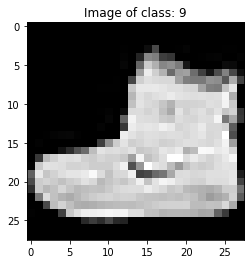

In [4]:
# Plotting the first sample picture.
# We need to reshape x, as it is currently of shape (1, 28, 28) 
# This is 3 dimensional, grayscale images should be 2 dimensional (28, 28).
plt.imshow(x.reshape(28,28), cmap='gray')
plt.title(f'Image of class: {y}');

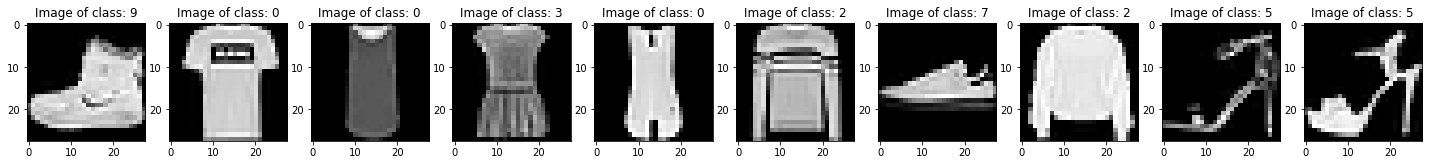

In [5]:
# Lets plot some more samples, to show how a dataset can be iterated:
fig, ax = plt.subplots(ncols=10, figsize=[25,5])
for i in range(10):
  x, y = training_data[i]
  ax[i].imshow(x.reshape(28,28), cmap='gray')
  ax[i].set_title(f'Image of class: {y}');

As we have just seen, a Pytorch dataset can be used to iterate over the samples and their labels. For training our neural network we want to feed our model all of the samples in the training dataset. When we loop over all of the data in the training dataset, we call this an epoch. During an epoch, we don't want to feed the model 1 image at a time. We also don't want to feed in all the data at once. The main reason for this, is that we want the model to see different images before it updates. We also want the model to update multiple times throughout the epoch so that it can already improve intermittently.

To solve these problems, we introduce batching. Batching splits the training datasets into multiple smaller chunks, these chunks are then fed through our model. After each chunk, the model can update. When the model has seen all chunks, it has seen the entire dataset and the epoch is over. To make these batches, we define a small class:

In [6]:
import torch
import random

class BatchSampler():
  """
  Implements an iterable which given a torch dataset and a batch_size
  will produce batches of data of that given size. The batches are
  returned as tuples in the form (images, labels).
  Can produce balanced batches, where each batch will have an equal 
  amount of samples from each class in the dataset. If your dataset is heavily
  imbalanced, this might mean throwing away a lot of samples from 
  over-represented classes!
  """

  def __init__(self, batch_size, dataset, balanced=False):
    self.batch_size = batch_size
    self.dataset = dataset
    self.balanced = balanced
    if self.balanced:
      # Counting the ocurrence of the class labels:
      unique, counts = np.unique(self.dataset.targets, return_counts=True) 
      indexes = []
      # Sampling an equal amount from each class:
      for i in range(len(unique)):
        indexes.append(np.random.choice(np.where(self.dataset.targets == i)[0], size=counts.min()), replace=False)
      # Setting the indexes we will sample from later:
      self.indexes = np.concatenate(indexes)
    else:
      # Setting the indexes we will sample from later (all indexes):
      self.indexes = [i for i in range(len(dataset))]


  def __len__(self):
    return (len(self.indexes) // self.batch_size) + 1
  
  def shuffle(self):
    # We do not need to shuffle if we use the balanced sampling method.
    # Shuffling is already done when making the balanced samples.
    if not self.balanced:
      random.shuffle(self.indexes)
    
  def __iter__(self):
    remaining = False
    self.shuffle()
    # Go over the datset in steps of 'self.batch_size':
    for i in range(0, len(self.indexes), self.batch_size):
        imgs, labels = [], []
        # If our current batch is larger than the remaining data, we quit:
        if i + self.batch_size > len(self.dataset):
          remaining = True
          break
        # If not, we yield a complete batch:
        else:
          # Getting a list of samples from the dataset, given the indexes we defined:
          X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, i + self.batch_size)]
          Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, i + self.batch_size)]
          # Stacking all the samples and returning the target labels as a tensor:
          yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()
    # If there is still data left that was not a full batch:
    if remaining:
      # Return the last batch (smaller than batch_size):
      batch = [self.dataset[self.indexes[k]] for k in range(i, len(self.indexes))]
      yield batch[0], torch.from_numpy(batch[1]).long()

Taking a good look at the above code, we can see we have full control over how we give data to our model. Lets test this out:

In [7]:
# We define our training sampler as an instance of the above defined class.
train_sampler = BatchSampler(batch_size=25, dataset=training_data, balanced=False)
# We can now loop over the batches, one at a time.
for batch in train_sampler:
  x, y = batch
  print(x.shape, y.shape)
  # After the first batch, we stop.
  break

torch.Size([25, 1, 28, 28]) torch.Size([25])


As you can see, we now have 25 images of (1,28,28) and 25 accompanying labels.
Lets now define a basic model:

In [8]:
from torchsummary import summary
import torch.nn as nn

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        # Initializing our parent class:
        super(NeuralNetwork, self).__init__()
        # We start with a flatten layer, to turn (1*28*28) into (784):
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # The first fully connected layer, from 784 to 512 neurons:
            nn.Linear(28*28, 512),
            # Our first activation function:
            nn.ReLU(),
            # The second fully connected layer, from 512 to 512 neurons:
            nn.Linear(512, 512),
            # Our second activation function:
            nn.ReLU(),
            # The final fully connected layer, from 512 to 10 neurons, 
            # one for each class (our dataset has 10 different classes).
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # Here we define how a sample X goes through our model.
        # We first feed it through the flatten layer:
        x = self.flatten(x)
        # We then run it through the fully connected layers:
        logits = self.linear_relu_stack(x)
        return logits

# Initializing the model and sending it to the correct device:
model = NeuralNetwork().to(device)
# Showing a summary of the model and its parameters:
summary(model, input_size=(1,28,28))

Using cpu device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


In [9]:
# Lets test our model by feeding 1 batch through it:
for batch in train_sampler:
  x, y = batch
  # Making sure our samples are stored on the same device as our model:
  x, y = x.to(device), y.to(device)
  predictions = model.forward(x)
  print(predictions.shape)
  break

torch.Size([25, 10])


We just fed the model 25 images, and it has outputted for each of these 10 images a number. We need to teach our model how it can be good at the task of classification. To do this, we need to define a loss function. Let's use a very simple example, mean squared error:

In [10]:
# We first need to create one-hot encoded labels so our true labels
# have the same shape as our predictions:
def one_hot_encode(labels):
  encoded_labels = []
  for k in range(len(labels)):
     encoded_labels.append([1 if labels[k] == i else 0 for i in range(10)])
  return torch.tensor(encoded_labels).to(device)

# Lets test it, with some example labels:
for batch in train_sampler:
  x, y = batch
  print(y, '\n', one_hot_encode(y))
  break

tensor([9, 1, 4, 4, 7, 2, 6, 9, 3, 7, 9, 7, 1, 6, 1, 2, 2, 4, 3, 8, 1, 4, 9, 7,
        7]) 
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0,

In [11]:
# Lets define our basic loss function:
def MSE(predictions, true_labels):
  return ((predictions - true_labels)**2).mean()

In [12]:
# Lets test our model by feeding 1 batch through it:
for batch in train_sampler:
  x, y = batch
  # Making sure our samples are stored on the same device as our model:
  x, y = x.to(device), y.to(device)
  predictions = model.forward(x)
  loss = MSE(predictions, one_hot_encode(y))
  print(loss)
  break

tensor(0.1067, grad_fn=<MeanBackward0>)


After having defined a way to judge how well our model is doing, we need something that makes our model change in such a way that we decrease our loss. For this we need an optimizer. Lets take a basic one from Pytorch:

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [14]:
# For fancy and easy progress bars:
from tqdm import tqdm

def train_model(model, train_sampler, optimizer):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Lets test our optimizer by feeding all batches through it (1 epoch):
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    # Making sure our samples are stored on the same device as our model:
    x, y = x.to(device), y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = MSE(predictions, one_hot_encode(y))
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

In [15]:
# Lets reset our model:
model = NeuralNetwork().to(device)
losses = train_model(model, train_sampler, optimizer)

100%|█████████▉| 2400/2401 [00:25<00:00, 92.62it/s]


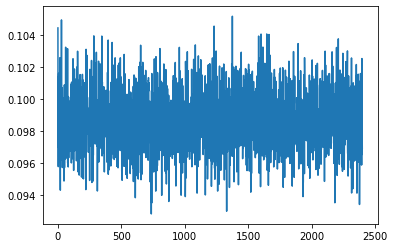

In [16]:
plt.plot(losses);

We can now inspect the losses over all the batches.
We see quite some fluctuations. 
To deal with this, we need to show our model all batches multiple times (epochs).

In [17]:
# Lets reset our model and optimizer:
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Lets now train our model for multiple epochs:
n_epochs = 10
mean_losses = []
for e in range(n_epochs):
  losses = train_model(model, train_sampler, optimizer)
  mean_loss = sum(losses) / len(losses)
  mean_losses.append(mean_loss)
  print(f'Epoch {e + 1} done, loss: {mean_loss}')

100%|█████████▉| 2400/2401 [00:28<00:00, 84.56it/s]


Epoch 1 done, loss: 0.039302319288253784


100%|█████████▉| 2400/2401 [00:28<00:00, 84.19it/s]


Epoch 2 done, loss: 0.02819639816880226


100%|█████████▉| 2400/2401 [00:27<00:00, 85.94it/s]


Epoch 3 done, loss: 0.02497018314898014


100%|█████████▉| 2400/2401 [00:28<00:00, 84.85it/s]


Epoch 4 done, loss: 0.023079227656126022


100%|█████████▉| 2400/2401 [00:28<00:00, 82.89it/s]


Epoch 5 done, loss: 0.02178085409104824


100%|█████████▉| 2400/2401 [00:29<00:00, 81.30it/s]


Epoch 6 done, loss: 0.020786846056580544


100%|█████████▉| 2400/2401 [00:29<00:00, 82.34it/s]


Epoch 7 done, loss: 0.019958658143877983


100%|█████████▉| 2400/2401 [00:29<00:00, 81.92it/s]


Epoch 8 done, loss: 0.019289258867502213


100%|█████████▉| 2400/2401 [00:28<00:00, 83.05it/s]


Epoch 9 done, loss: 0.018672242760658264


100%|█████████▉| 2400/2401 [00:28<00:00, 83.14it/s]

Epoch 10 done, loss: 0.018166905269026756


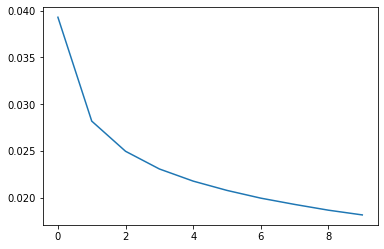

In [18]:
plt.plot(mean_losses);

The loss now nicely decreases over the epochs. We now want to know how our model is actually doing at it's prediction task. Mean squared error is maybe not so easy to interpret. We can use accuracy instead! Lets evaluate our model by running it on the test set:

In [19]:
def test_model(model, test_data):
  # Setting the model to evaluation mode:
  model.eval()
  correct = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_data):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      prediction = model.forward(x)
      # Our loss function, will make sure that our model will try to predict a value
      # close to 1 for the class it thinks the sample is, and a value close to 0
      # for classes that the sample is not from.
      label = abs(prediction - 1).argmin()
      correct.append(label == y)
  return correct

In [20]:
# Lets calculate our prediction accuracy on the test set:
correct = test_model(model, test_data)
sum(correct)/len(correct)

100%|██████████| 10000/10000 [00:04<00:00, 2128.59it/s]


tensor(0.8730)

The accuracy on the test set is a good way to judge how your model is doing during training. For example, if the test accuracy does not increase while the training loss is decreasing, your model might be overfitting.
Lets define our training and testing procedure all at once: 

In [21]:
# Lets reset our model and optimizer:
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Lets now train and test our model for multiple epochs:
n_epochs = 15
mean_losses = []
accuracies = []
for e in range(n_epochs):
  # Training:
  losses = train_model(model, train_sampler, optimizer)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses.append(mean_loss)
  print(f'\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n')

  # Testing:
  correct = test_model(model, test_data)
  # Calculating and printing statistics:
  accuracy = sum(correct) / len(correct)
  accuracies.append(accuracy)
  print(f'\nEpoch {e + 1} testing done, accuracy on test set: {accuracy}\n')


100%|█████████▉| 2400/2401 [00:28<00:00, 82.94it/s]



Epoch 1 training done, loss on train set: 0.03909042477607727



100%|██████████| 10000/10000 [00:04<00:00, 2219.26it/s]



Epoch 1 testing done, accuracy on test set: 0.8062999844551086



100%|█████████▉| 2400/2401 [00:28<00:00, 83.13it/s]



Epoch 2 training done, loss on train set: 0.028060995042324066



100%|██████████| 10000/10000 [00:04<00:00, 2258.99it/s]



Epoch 2 testing done, accuracy on test set: 0.838100016117096



100%|█████████▉| 2400/2401 [00:29<00:00, 82.70it/s]



Epoch 3 training done, loss on train set: 0.02494904212653637



100%|██████████| 10000/10000 [00:04<00:00, 2237.45it/s]



Epoch 3 testing done, accuracy on test set: 0.8452000021934509



100%|█████████▉| 2400/2401 [00:29<00:00, 82.37it/s]



Epoch 4 training done, loss on train set: 0.02308584377169609



100%|██████████| 10000/10000 [00:04<00:00, 2287.71it/s]



Epoch 4 testing done, accuracy on test set: 0.8514000177383423



100%|█████████▉| 2400/2401 [00:28<00:00, 83.21it/s]



Epoch 5 training done, loss on train set: 0.02176983281970024



100%|██████████| 10000/10000 [00:04<00:00, 2156.88it/s]



Epoch 5 testing done, accuracy on test set: 0.853600025177002



100%|█████████▉| 2400/2401 [00:28<00:00, 84.16it/s]



Epoch 6 training done, loss on train set: 0.020810609683394432



100%|██████████| 10000/10000 [00:04<00:00, 2290.42it/s]



Epoch 6 testing done, accuracy on test set: 0.8640000224113464



100%|█████████▉| 2400/2401 [00:28<00:00, 83.77it/s]



Epoch 7 training done, loss on train set: 0.01996777206659317



100%|██████████| 10000/10000 [00:04<00:00, 2278.38it/s]



Epoch 7 testing done, accuracy on test set: 0.8672999739646912



100%|█████████▉| 2400/2401 [00:29<00:00, 82.56it/s]



Epoch 8 training done, loss on train set: 0.01927337422966957



100%|██████████| 10000/10000 [00:04<00:00, 2232.54it/s]



Epoch 8 testing done, accuracy on test set: 0.8704000115394592



100%|█████████▉| 2400/2401 [00:28<00:00, 83.69it/s]



Epoch 9 training done, loss on train set: 0.01870124042034149



100%|██████████| 10000/10000 [00:04<00:00, 2287.17it/s]



Epoch 9 testing done, accuracy on test set: 0.8698999881744385



100%|█████████▉| 2400/2401 [00:28<00:00, 84.82it/s]



Epoch 10 training done, loss on train set: 0.018143970519304276



100%|██████████| 10000/10000 [00:04<00:00, 2279.24it/s]



Epoch 10 testing done, accuracy on test set: 0.8734999895095825



100%|█████████▉| 2400/2401 [00:28<00:00, 84.01it/s]



Epoch 11 training done, loss on train set: 0.01767425611615181



100%|██████████| 10000/10000 [00:04<00:00, 2277.65it/s]



Epoch 11 testing done, accuracy on test set: 0.8730999827384949



100%|█████████▉| 2400/2401 [00:28<00:00, 84.03it/s]



Epoch 12 training done, loss on train set: 0.01727544702589512



100%|██████████| 10000/10000 [00:04<00:00, 2261.45it/s]



Epoch 12 testing done, accuracy on test set: 0.8766000270843506



100%|█████████▉| 2400/2401 [00:28<00:00, 83.90it/s]



Epoch 13 training done, loss on train set: 0.016833966597914696



100%|██████████| 10000/10000 [00:04<00:00, 2325.74it/s]



Epoch 13 testing done, accuracy on test set: 0.8812999725341797



100%|█████████▉| 2400/2401 [00:28<00:00, 84.00it/s]



Epoch 14 training done, loss on train set: 0.01647600345313549



100%|██████████| 10000/10000 [00:04<00:00, 2254.52it/s]



Epoch 14 testing done, accuracy on test set: 0.8787000179290771



100%|█████████▉| 2400/2401 [00:28<00:00, 83.79it/s]



Epoch 15 training done, loss on train set: 0.0161331407725811



100%|██████████| 10000/10000 [00:04<00:00, 2171.60it/s]


Epoch 15 testing done, accuracy on test set: 0.8774999976158142



Lets inspect our loss and accuracy after the model has been trained and tested for 15 epochs:

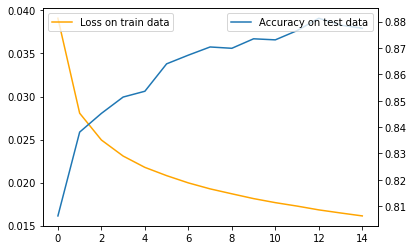

In [22]:
fig, ax = plt.subplots()
ax.plot(mean_losses, label='Loss on train data', c='orange')
ax.legend(loc=2)
ax = ax.twinx()
ax.plot(accuracies, label='Accuracy on test data');
ax.legend(loc=1);

This looks as expected, over the epochs the loss on the training data decreases. If this is not the case, our model is not sufficiently complex to learn anything from the data. What is good to see is that the accuracy on the test set went up over the epochs. This indicates the model generalized well. If this is not the case, the model is overfitting.

There are a lot of layers we could have added to the model to improve it's performance. A nice overview can be found [here](https://pytorch.org/docs/stable/nn.html).

More information about the technical aspects of Pytorch is explained [here](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html), [here](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) and [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

For computer vision, transfer learning is a technique that might yield better results. You can find a Pytorch tutorial of this [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).